In [1]:
import numpy as np
from numpy.random import normal, uniform
from scipy.stats import multivariate_normal as mv_norm
import matplotlib.pyplot as plt
%matplotlib inline

def real_function(a_0, a_1, noise_sigma, x):
    """
    Evaluates the real function
    """
    N = len(x)
    if noise_sigma==0:
        # Recovers the true function
        return a_1 + a_0*x
    else:
        return a_1 + a_0*x + normal(0, noise_sigma, N)
    
    
class LinearBayes(object):
    """
    A class that holds parameter prior/posterior and handles 
    the hyper-parameter updates with new data
    
    Note:  variables starting with "v_" indicate Nx1 dimensional 
        column vectors, those starting with "m_" indicate 
        matrices, and those starting with "a_" indicate 
        1xN dimensional arrays.
    
    Args:
        a_m0 (np.array): prior mean vector of size 1xM
        m_S0 (np.ndarray): prior covariance matrix of size MxM
        beta (float): known real-data noise precision
        
    """
    def __init__(self, a_m0, m_S0, beta):
        self.prior = mv_norm(mean=a_m0, cov=m_S0)
        self.v_m0 = a_m0.reshape(a_m0.shape + (1,)) #reshape to column vector
        self.m_S0 = m_S0
        self.beta = beta
        
        self.v_mN = self.v_m0
        self.m_SN = self.m_S0
        self.posterior = self.prior
           
    def get_phi(self, a_x):
        """
        Returns the design matrix of size (NxM) for a feature vector v_x.
        In this case, this function merely adds the phi_0 dummy basis
        that's equal to 1 for all elements.
        
        Args:
            a_x (np.array): input features of size 1xN
        """
        m_phi = np.ones((len(a_x), 2))
        m_phi[:, 1] = a_x
        return m_phi
        
    def set_posterior(self, a_x, a_t):
        """
        Updates mN and SN given vectors of x-values and t-values
        """
        # Need to convert v_t from an array into a column vector
        # to correctly compute matrix multiplication
        v_t = a_t.reshape(a_t.shape + (1,))

        m_phi = self.get_phi(a_x)
        
        self.m_SN = np.linalg.inv(np.linalg.inv(self.m_S0) + self.beta*m_phi.T.dot(m_phi))
        self.v_mN = self.m_SN.dot(np.linalg.inv(self.m_S0).dot(self.v_m0) + \
                                      self.beta*m_phi.T.dot(v_t))
        
        self.posterior = mv_norm(mean=self.v_mN.flatten(), cov=self.m_SN)

    
    def prediction_limit(self, a_x, stdevs):
        """
        Calculates the limit that's "stdevs" standard deviations
        away from the mean at a given value of x.
        
        Args:
            a_x (np.array): x-axis values of size 1xN
            stdevs (float): Number of standard deviations away from
                the mean to calculate the prediction limit
        
        Returns:
            np.array: the prediction limit "stdevs" standard deviations
                away from the mean corresponding to x-values in "v_x"
        
        """
        N = len(a_x)
        m_x = self.get_phi(a_x).T.reshape((2, 1, N))
        
        predictions = []
        for idx in range(N):
            x = m_x[:,:,idx]
            sig_sq_x = 1/self.beta + x.T.dot(self.m_SN.dot(x))
            mean_x = self.v_mN.T.dot(x)
            predictions.append((mean_x+stdevs*np.sqrt(sig_sq_x)).flatten())
        return np.concatenate(predictions)
    
    def generate_data(self, a_x):
        N = len(a_x)
        m_x = self.get_phi(a_x).T.reshape((2, 1, N))
        
        predictions = []
        for idx in range(N):
            x = m_x[:,:,idx]
            sig_sq_x = 1/self.beta + x.T.dot(self.m_SN.dot(x))
            mean_x = self.v_mN.T.dot(x)
            predictions.append(normal(mean_x.flatten(), np.sqrt(sig_sq_x)))
        return np.array(predictions)
    
    def make_contour(self, a_x, a_y, real_parms=[], N=0):
        """
        A helper function to generate contour plots of our probability distribution
        """
        pos = np.empty(a_x.shape + (2,))
        pos[:, :, 0] = a_x
        pos[:, :, 1] = a_y

        plt.contourf(a_x, a_y, self.posterior.pdf(pos), 20)
        plt.xlabel('$w_0$', fontsize=16)
        plt.ylabel('$w_1$', fontsize=16)
        
        if real_parms:
            plt.scatter(real_parms[0], real_parms[1], marker='+', c='black', s=60)
            
            plt.title('Prior distribution of the Weight Parameters with %d datapoint(s)' % N, fontsize=10)
    
    def make_scatter(self, a_x, a_t, real_parms, samples=None, stdevs=None):
        """
        A helper function to plot noisey data, the true function, 
        and optionally a set of lines specified by the nested array of
        weights of size NxM where N is number of lines, M is 2 for 
        this simple model
        """
        plt.scatter(a_x, a_t, alpha=0.5)
        plt.xlabel('x')
        plt.ylabel('t')

        plt.plot([-1, 1], real_function(real_parms[0], real_parms[1], 0, np.array([-1., 1.])), 'r')

        plt.title('Data with normally distributed noise')
        
        if samples:
            weights = self.posterior.rvs(samples)
            for weight in weights: 
                plt.plot([-1, 1], real_function(weight[1], weight[0], 0, np.array([-1., 1.])), 'black')
                plt.title('Lines Sampled from Posterior Distribution vs Real Line and Data')
        
        if stdevs:
            a_xrange = np.linspace(-1, 1, 100)
            y_upper = self.prediction_limit(a_xrange, stdevs)
            y_lower = self.prediction_limit(a_xrange, -stdevs)
            plt.plot(a_xrange, y_upper, '+', c='green', linewidth=4.0)
            plt.plot(a_xrange, y_lower, '+', c='green', linewidth=4.0)
            plt.title('Lines Sampled from Posterior Distribution vs Real Line and Data')


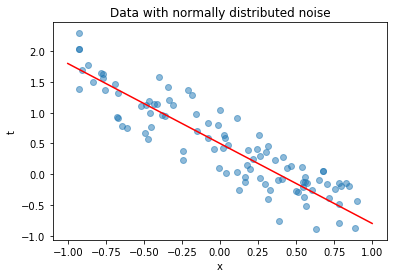

In [2]:
# Real function parameters
a_0 = -1.3
a_1 = 0.5
noise_sigma = 0.3
beta = 1/noise_sigma**2
# Generate input features from uniform distribution
np.random.seed(20) # Set the seed so we can get reproducible results
x_real = uniform(-1, 1, 100)
# Evaluate the real function for training example inputs
t_real = real_function(a_0, a_1, noise_sigma, x_real)

alpha = 2.0
v_m0 = np.array([0., 0.])
m_S0 = 1/alpha*np.identity(2)

linbayes = LinearBayes(v_m0, m_S0, beta)

linbayes.make_scatter(x_real, t_real, real_parms = [a_0, a_1])


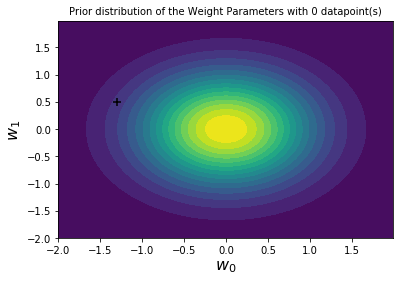

In [3]:
x, y = np.mgrid[-2:2:.01, -2:2:.01]
linbayes.make_contour(x, y, real_parms=[a_0, a_1], N=0)

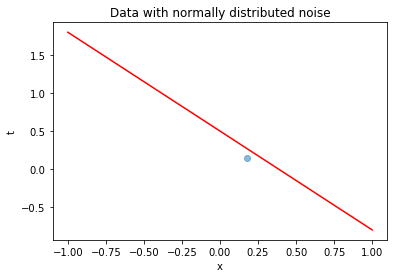

In [4]:
N=1
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1])

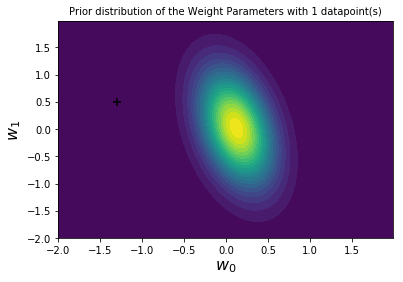

In [5]:
linbayes.set_posterior(x_real[0:N], t_real[0:N])
linbayes.make_contour(x, y, real_parms=[a_0, a_1], N=N)

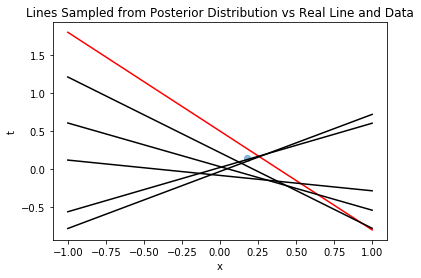

In [6]:
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1], samples=5)

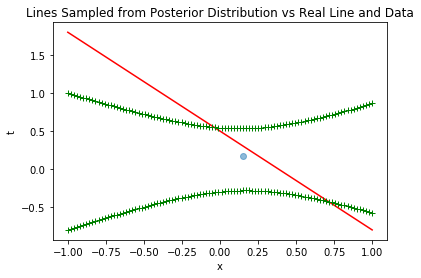

In [7]:
linbayes.make_scatter(t_real[0:N], x_real[0:N], real_parms=[a_0, a_1], stdevs=1)

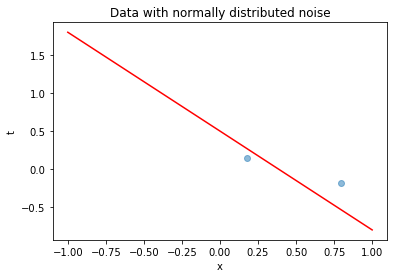

In [8]:
N=2
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1])

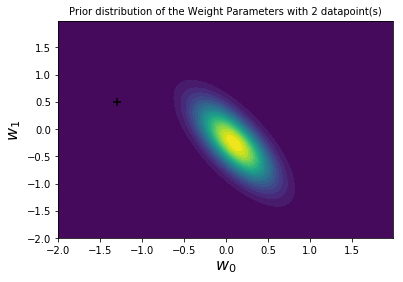

In [9]:
linbayes.set_posterior(x_real[0:N], t_real[0:N])
linbayes.make_contour(x, y, real_parms=[a_0, a_1], N=N)


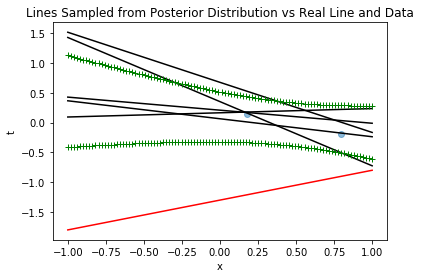

In [10]:
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_1, a_0], samples=5, stdevs=1)

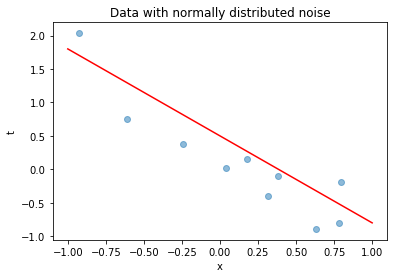

In [11]:
N=10
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1])

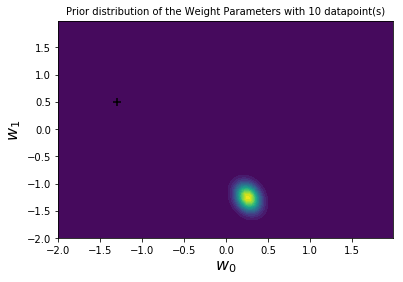

In [12]:
linbayes.set_posterior(x_real[0:N], t_real[0:N])
linbayes.make_contour(x, y, real_parms=[a_0, a_1], N=N)

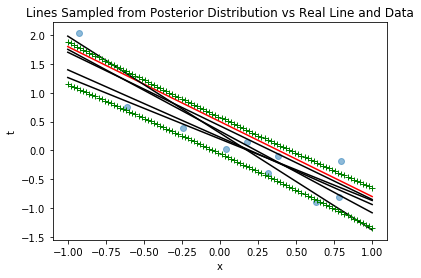

In [13]:
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1], samples=5, stdevs=1)

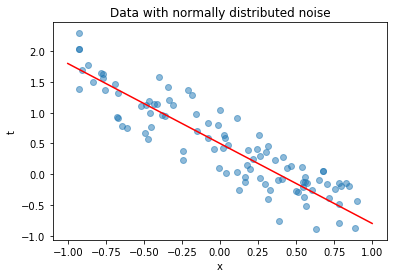

In [14]:
N=100
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1])

In [15]:
linbayes.set_posterior(x_real[0:N], t_real[0:N])
linbayes.make_contour(x, y, real_parms=[a_0, a_1], N = N

SyntaxError: unexpected EOF while parsing (<ipython-input-15-54320b4fefef>, line 2)

In [ ]:
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1], samples=5, stdevs=1)